In [ ]:
#! pip install tensorflow==2.18.0 scipy==1.14.1 numpy==2.0.2 matplotlib==3.10.0

In [ ]:
! pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.5.2
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.14.0.37.22
astunparse                            1.6.3
atpublic                              5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


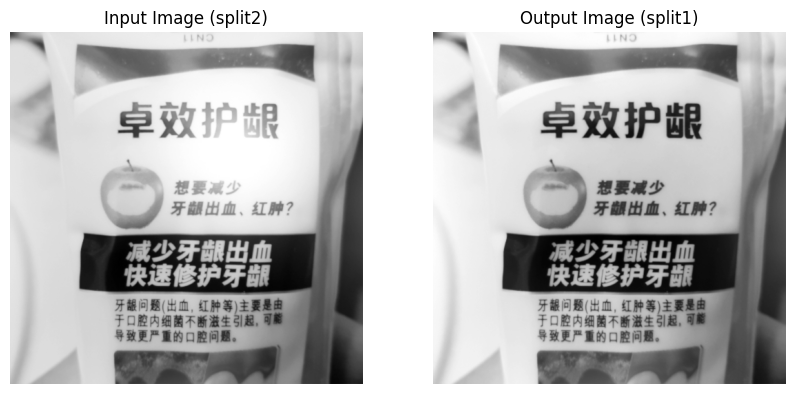

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

def parse_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # Force 1 channel (grayscale)
    img = tf.cast(img, tf.float32) / 255.0

    # Split 1024-width image into left/right halves
    split1 = img[:, :512, :]   # Output (left)
    split2 = img[:, 512:1024, :]  # Input (right)

    return split2, split1  # Return input, output

def load_data(data_dir):
    file_paths = tf.data.Dataset.list_files(data_dir + '/*.png')

    def map_to_pair(file_path):
        return parse_image(file_path)

    dataset = file_paths.map(map_to_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_data('/content/drive/MyDrive/interview_HTX/SD1_Trimmed/train')
val_dataset = load_data('/content/drive/MyDrive/interview_HTX/SD1_Trimmed/val')

# Visualization
for image_batch, label_batch in train_dataset.take(1):
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_batch[0].squeeze(), cmap='gray')
    plt.title("Input Image (split2)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label_batch[0].squeeze(), cmap='gray')
    plt.title("Output Image (split1)")
    plt.axis('off')

    plt.show()


In [2]:
import matplotlib.pyplot as plt

def model_matrics(history):
    # Create a figure with a single axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the training and validation loss on the first y-axis (left)
    ax1.plot(history.history['loss'], label='Training', color='b')
    ax1.plot(history.history['val_loss'], label='Validation', color='y')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Add a title and a legend
    fig.suptitle('Training Loss vs Validation Loss - Highlight Removal')
    fig.tight_layout()  # Adjust layout to prevent overlap

    # Add legends
    ax1.legend(loc='upper right')

    # Show the plot
    plt.show()


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 361s 662ms/step - loss: 0.0187 - mae: 0.1002 - val_loss: 0.0055 - val_mae: 0.0489
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 223s 585ms/step - loss: 0.0058 - mae: 0.0519 - val_loss: 0.0043 - val_mae: 0.0464
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 581ms/step - loss: 0.0036 - mae: 0.0416 - val_loss: 0.0031 - val_mae: 0.0442
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 223s 583ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0019 - val_mae: 0.0297
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 221s 582ms/step - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0032 - val_mae: 0.0366
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 222s 583ms/step - loss: 0.0017 - mae: 0.0284 - val_loss: 0.0012 - val_mae: 0.0238
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 578ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0011 - val_mae: 0.0232
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 262s 579ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0013 - val_mae: 0.0239
Epoch 9/10
375/375 ━━━━━

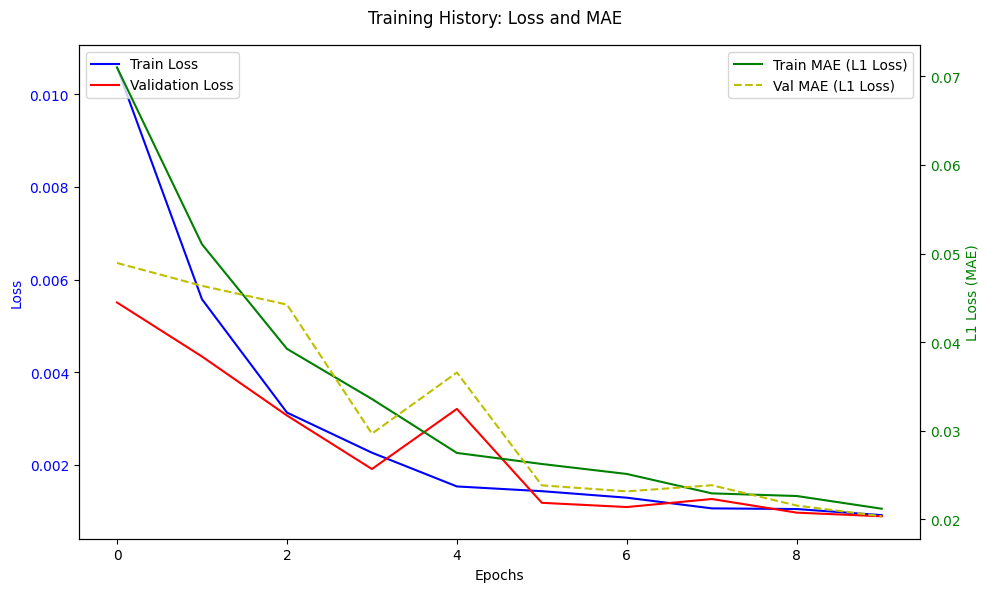

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
def build_unet(input_shape=(512, 512, 1)):
    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        return x

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return models.Model(inputs, outputs)

unet = build_unet()
unet.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

unet.save('/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet.h5')
model_matrics(history)

Input batch shape: (8, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


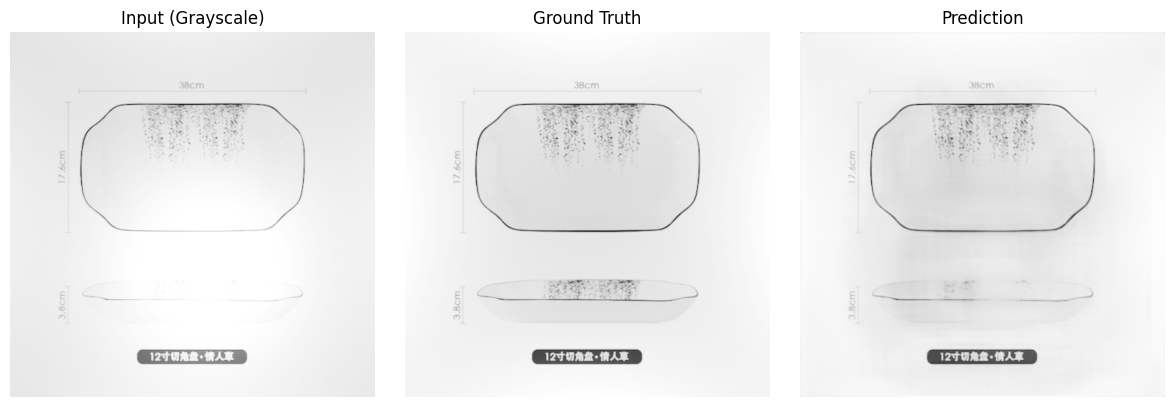

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take a batch from the validation dataset
model_path = '/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet.h5'
model = tf.keras.models.load_model(model_path)
for input_batch, output_batch in val_dataset.take(1):
    # Check the shape of input_batch
    print("Input batch shape:", input_batch.shape)

    # If the input batch has 3 channels (RGB), convert to grayscale
    if input_batch.shape[-1] == 3:
        grayscale_input_batch = tf.image.rgb_to_grayscale(input_batch)
    else:
        # If it's already grayscale, no need to convert
        grayscale_input_batch = input_batch

    # Resize to ensure the shape is 512x512 (if necessary)
    grayscale_input_batch = tf.image.resize(grayscale_input_batch, (512, 512))

    # Make predictions using the model
    predictions = model.predict(grayscale_input_batch)
    break


# Visualize the first input-output-prediction triplet
plt.figure(figsize=(12, 4))

# Input image (grayscale)
plt.subplot(1, 3, 1)
plt.title("Input (Grayscale)")
plt.imshow(grayscale_input_batch[0, :, :, 0], cmap='gray')  # Only plot the grayscale channel
plt.axis('off')

# Ground truth (original)
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(output_batch[0, :, :, 0], cmap='gray')  # Assuming output is grayscale as well
plt.axis('off')

# Prediction
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(predictions[0, :, :, 0], cmap='gray')  # Assuming prediction is grayscale
plt.axis('off')

plt.tight_layout()
plt.show()



In [4]:
'''
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
def build_unet_with_pretrained_encoder(input_shape=(512, 512, 1)):
    # Use the VGG16 encoder (without top layer, include pre-trained weights)
    # Accept 1-channel input
    inputs = Input(shape=input_shape)

    # Repeat grayscale channel to match VGG16's 3-channel requirement
    x = layers.Concatenate()([inputs, inputs, inputs])  # Now (512, 512, 3)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=x)

    # Encoder
    c1 = vgg16.get_layer('block1_conv1').output
    c2 = vgg16.get_layer('block2_conv1').output
    c3 = vgg16.get_layer('block3_conv1').output
    c4 = vgg16.get_layer('block4_conv1').output

    # Decoder and rest of U-Net
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c4)
    u6 = layers.concatenate([u6, c3])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    model = models.Model(inputs=vgg16.input, outputs=outputs)
    return model

unet = build_unet_with_pretrained_encoder()
unet.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

unet.save('/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet_pretrained.h5')
model_matrics(history)
'''

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_30']
Received: inputs=Tensor(shape=(None, None, None, 1))
  warnings.warn(msg)


  4/375 ━━━━━━━━━━━━━━━━━━━━ 11:01 2s/step - loss: 0.1560 - mae: 0.3472

KeyboardInterrupt: 

In [ ]:
'''
import matplotlib.pyplot as plt
import tensorflow as tf

# Take a batch from the validation dataset
model_path = '/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet_pretrained.h5'
model = tf.keras.models.load_model(model_path)
for input_batch, output_batch in val_dataset.take(1):
    # Check the shape of input_batch
    print("Input batch shape:", input_batch.shape)

    # If the input batch has 3 channels (RGB), convert to grayscale
    if input_batch.shape[-1] == 3:
        grayscale_input_batch = tf.image.rgb_to_grayscale(input_batch)
    else:
        # If it's already grayscale, no need to convert
        grayscale_input_batch = input_batch

    # Resize to ensure the shape is 512x512 (if necessary)
    grayscale_input_batch = tf.image.resize(grayscale_input_batch, (512, 512))

    # Make predictions using the model
    predictions = model.predict(grayscale_input_batch)
    break


# Visualize the first input-output-prediction triplet
plt.figure(figsize=(12, 4))

# Input image (grayscale)
plt.subplot(1, 3, 1)
plt.title("Input (Grayscale)")
plt.imshow(grayscale_input_batch[0, :, :, 0], cmap='gray')  # Only plot the grayscale channel
plt.axis('off')

# Ground truth (original)
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(output_batch[0, :, :, 0], cmap='gray')  # Assuming output is grayscale as well
plt.axis('off')

# Prediction
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(predictions[0, :, :, 0], cmap='gray')  # Assuming prediction is grayscale
plt.axis('off')

plt.tight_layout()
plt.show()

'''

In [ ]:
'''
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import scipy.io
import numpy as np

# Load VGG19 weights from .mat file
vgg_path = '/content/drive/MyDrive/interview_HTX/VGG_Model/imagenet-vgg-verydeep-19.mat'
vgg_data = scipy.io.loadmat(vgg_path)
vgg_layers  = vgg_data['layers'][0]

# Function to load weights and biases
def get_weights(layer_index, grayscale=False):
    weights = vgg_layers[layer_index][0][0][2][0][0]  # shape: (3, 3, 3, n_filters)
    biases = vgg_layers[layer_index][0][0][2][0][1]

    if grayscale:
        # Average over the 3 RGB channels to get 1 grayscale channel
        weights = np.mean(weights, axis=2, keepdims=True)  # shape: (3, 3, 1, n_filters)

    return weights, biases.reshape(-1)

# Build a model that takes 1-channel grayscale input and outputs grayscale

def build_vgg19_model_grayscale():
    model = models.Sequential()
    model.add(layers.Input(shape=(512, 512, 1)))  # Grayscale input

    # Conv1_1
    weights, biases = get_weights(0, grayscale=True)
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.layers[-1].set_weights([weights, biases])

    # Conv1_2
    weights, biases = get_weights(2, grayscale=False)  # Now previous layer has 64 channels
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.layers[-1].set_weights([weights, biases])

    # You can add more layers here if needed, following the same logic and converting weights manually

    # Output layer for glare removal (1-channel grayscale output)
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    return model

# Build and compile the model
model = build_vgg19_model_grayscale()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

# Save the trained model
model.save('/content/drive/MyDrive/interview_HTX/grayscale.h5')
model_matrics(history)
'''